In [1]:
#from google.colab import drive
#drive.mount('/content/drive')



In [20]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image
from itertools import cycle

# import data handling tools
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import label_binarize


# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras import Sequential
from tensorflow.keras import layers


# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

devider = "-------------------------------------------------------------------------------------------------------------------------------------"
print ('modules loaded')

modules loaded


In [ ]:
# Replace these paths with the actual paths to your dataset folders
data_dir = 'INSERT-OWN-DRIVE-OR-DIR-WHERE-IMG-PRESENT'


filepaths = []
image_data = []
labels = []


folds = os.listdir(data_dir)

for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    flist = os.listdir(foldpath)

    for f in flist:
        f_path = os.path.join(foldpath , f)
        filelist = os.listdir(f_path)

        for file in filelist:
            fpath = os.path.join(f_path , file)
            try:
              # Open the image using PIL (or you can use OpenCV) within a 'with' statement
              with Image.open(fpath) as image:
                if image is not None:
                  # Resize images
                  im = image.resize((120,120), Image.LANCZOS)
                  # Append image and label to respective lists
                  image_data.append(np.array(im))
                else:
                  print(f"Error opening image '{fpath}': NoneType object returned")
            except Exception as e:
              print(f"Error opening image '{fpath}': {e}")
            # Assign the label of the images according to the folder they belongs to.
            if f == 'colon_aca':
                labels.append('Colon adenocarcinoma')

            elif f == 'colon_n':
                labels.append('Colon Benign Tissue')

            elif f == 'lung_aca':
                labels.append('Lung adenocarcinoma')

            elif f == 'lung_n':
                labels.append('Lung Benign Tissue')

            elif f == 'lung_scc':
                labels.append('Lung Squamous Cell Carcinoma')

tr_labels = np.array(labels)
image_matrix = np.array([np.array(img) for img in image_data])

np.save("location/yourownname.npy",image_matrix) # Saving as a npy file so that we can just load it later
np.save("location/yourownname.npy",tr_labels)


In [21]:
# Cheek if tensorflow has been initiated in GPU mode
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


2.15.0
Num GPUs Available:  1


# Loading the data

In [22]:
file_dir = "/mnt/c/Users/user/Desktop/Deep learning assignmnet/test/"
data = np.load(file_dir + "data120.npy")
labels = np.load(file_dir + "labels120.npy", allow_pickle=True)
print(labels)



['Colon adenocarcinoma' 'Colon adenocarcinoma' 'Colon adenocarcinoma' ...
 'Lung Squamous Cell Carcinoma' 'Lung Squamous Cell Carcinoma'
 'Lung Squamous Cell Carcinoma']


# Preprocessing and EDA (Exploratory Data Analysis)


## Converting the Target Values to the One-Hot-Encoded Format

In [23]:


num_classes=len(np.unique(labels))
print(f'num of classes = {num_classes}')
# 5 Different cancers

# Reshape labels to (-1, 1) because it's a single feature
labels1 = labels.reshape(-1, 1)

# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse=False)  # Use sparse=False to get a dense array

# Fit and transform the labels
labels1 = encoder.fit_transform(labels1)

# one_hot_labels is now a one-hot encoded representation of your labels
print(labels1)

# To get the feature names (class names in this case) after encoding
feature_names = encoder.get_feature_names_out(input_features=['labels'])
print(feature_names)

# The one hot encoded labels are present in the variable labels1
# This ussage of naming is done to adhere to later checks...



num of classes = 5
[[0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 ...
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]]
['labels_Colon Benign Tissue' 'labels_Colon adenocarcinoma'
 'labels_Lung Benign Tissue' 'labels_Lung Squamous Cell Carcinoma'
 'labels_Lung adenocarcinoma']


## Visualizing Sample Images

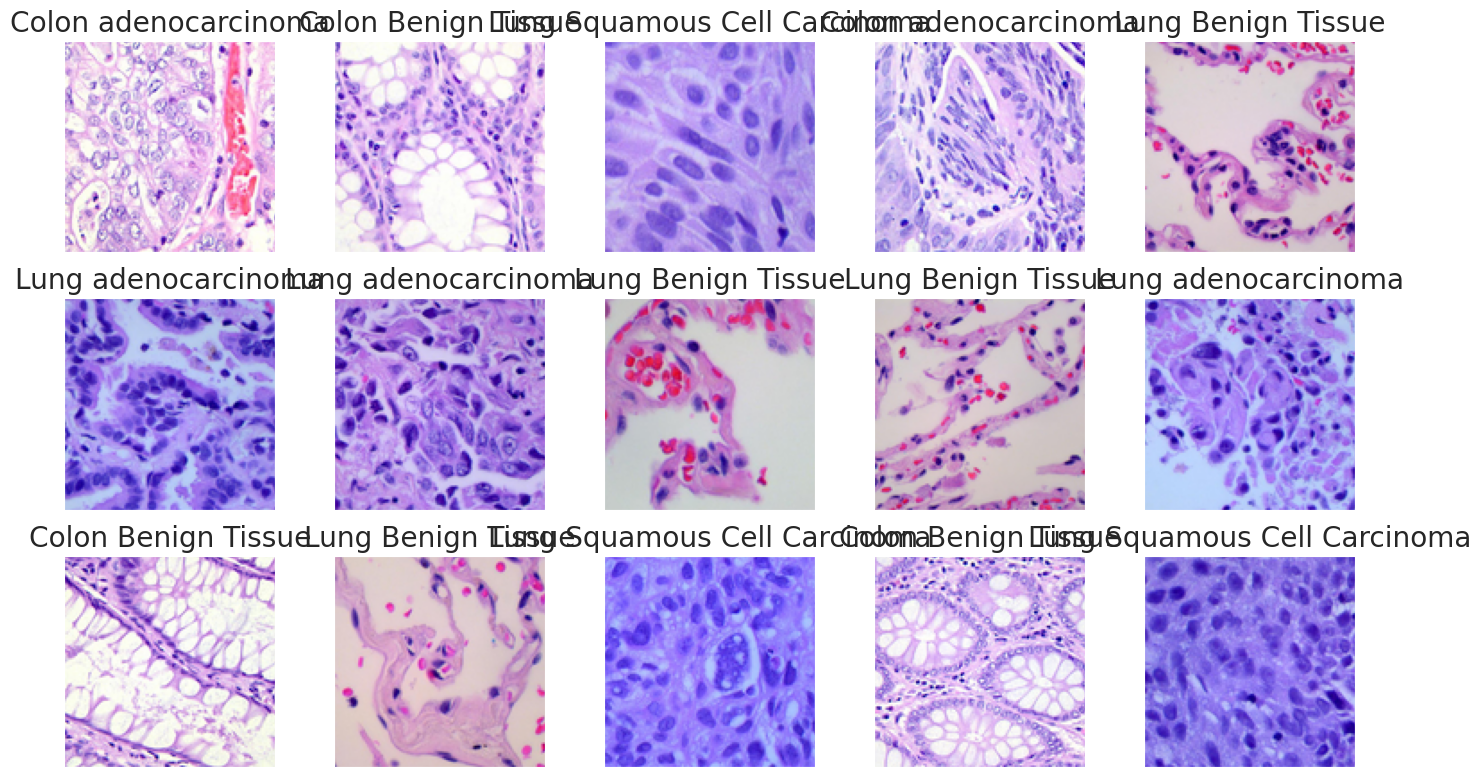

In [24]:

# data is the images array and `labels` is an array of labels
def imgshower(data, labels):
    # Generate 15 unique random indices
    random_indices = np.random.choice(data.shape[0], 15, replace=False)

    # Set up the matplotlib figure and axes,
    # assuming a 3x5 grid for 15 images
    fig, axs = plt.subplots(3, 5, figsize=(15, 9))

    for ax, idx in zip(axs.flat, random_indices):
        # Display image
        ax.imshow(data[idx])
        # Display label
        label = labels[idx]  # Assuming labels are not one-hot encoded
        ax.set_title(label)
        # Hide axes ticks
        ax.set_xticks([])
        ax.set_yticks([])


    plt.show()

# Example usage
imgshower(data, labels)


## Visualizing Class Distribution

Total number of observations per unique class: [5000. 5000. 5000. 5000. 5000.]


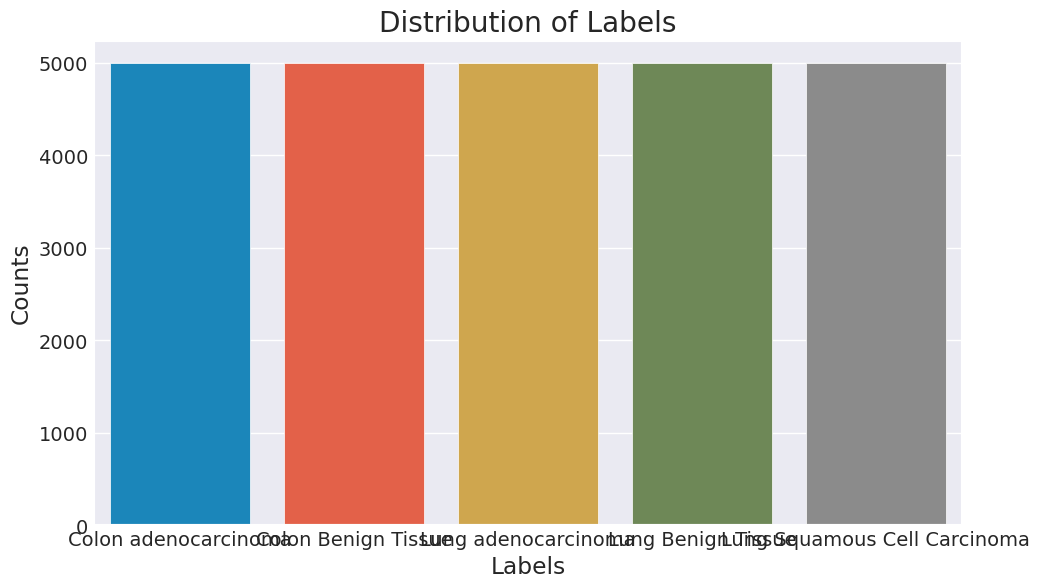

In [25]:
class_counts = np.sum(labels1 , axis= 0)
print(f"Total number of observations per unique class: {class_counts}")

# convert to pd dataframe for easier navigation
labels_series = pd.Series(labels)
# create the plot
plt.figure(figsize=(10,6))
sns.countplot(x = labels_series, order = labels_series.value_counts().index)
plt.title('Distribution of Labels')
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.show()

# labels are uniformly distributed also confirmed from class_counts which is created
# from variable labels1 and not labels

### Splitting the data


To split the data a four step procedure is followed:
1. Preliminary check to ensure labels order was preserved after encoding

2. Split data into training and temporary set(temporary set will be further split into validation and test sets)

3. We use the original labels array for
   stratification to ensure each split has proportional representation of each class
   unify data types for both labels1 and data
4. Function to verify if the split preserved the order of samples correctly


In [26]:

# Starting step 1

labels_reversed = encoder.inverse_transform(labels1)
# Since labels_reversed will be in the shape (-1, 1), we must flatten it
# for a direct comparison
labels_reversed = labels_reversed.flatten()
# Check if the original labels and the reversed labels match
matching_labels = np.array_equal(labels, labels_reversed)
print(f"Do the original and reversed labels match? {matching_labels}")

# Starting step 2
indices = np.arange(data.shape[0])

x_train, x_temp, y_train, y_temp, indices_train, indices_temp = train_test_split(
    data, labels1, indices, test_size=0.4, random_state=42, stratify=labels1)

# starting Step 3
x_val, x_test, y_val, y_test, indices_val, indices_test = train_test_split(
    x_temp, y_temp, indices_temp, test_size=0.5, random_state=42, stratify=y_temp)


# Starting step 4 -OPTIONAL REMOVED AFTER THE FIRST RUN SINCE CHEECK HOLDS <------------------------

# def verify_split(indices, x, y, original_data, original_labels):
#     for i, index in enumerate(indices):
#         if not np.array_equal(x[i], original_data[index]) or not np.array_equal(y[i], original_labels[index]):
#             return False
#     return True

#train_verified = verify_split(indices_train, x_train, y_train, data, labels1)
#val_verified = verify_split(indices_val, x_val, y_val, data, labels1)
#test_verified = verify_split(indices_test, x_test, y_test, data, labels1)

# Showcasing results

#print("Index check is a pass:",
     # f"Train data: {train_verified}",
     # f"Validation data: {val_verified}",
     # f"Test data: {test_verified}")


print("Data spliting procedure is finalized showcasing results: ")
print(f"Training set shape: {x_train.shape}, {y_train.shape}")
print(f"Validation set shape: {x_val.shape}, {y_val.shape}")
print(f"Test set shape: {x_test.shape}, {y_test.shape}")
print("Split and check complete")





Do the original and reversed labels match? True
Data spliting procedure is finalized showcasing results: 
Training set shape: (15000, 120, 120, 3), (15000, 5)
Validation set shape: (5000, 120, 120, 3), (5000, 5)
Test set shape: (5000, 120, 120, 3), (5000, 5)
Split and check complete


# Evaluation Functions

## Loss - Acc graphs:

In [27]:
def plot_training_history(history, figsize=(20, 8)):
    # Extracting the history records
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    # Finding the best/worst epochs
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    # Preparing epoch labels
    Epochs = [i+1 for i in range(len(train_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plotting
    plt.figure(figsize=figsize)
    plt.style.use('fivethirtyeight')

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, train_loss, 'r', label='Training loss')
    plt.plot(Epochs, val_loss, 'g', label='Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(Epochs, train_acc, 'r', label='Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
    plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


## Classification Report and Confusion matrix:

In [28]:
# Function to calculate and print performance metrics
def print_performance_metrics(y_true, y_pred_labels):
    accuracy = accuracy_score(y_true, y_pred_labels)
    precision = precision_score(y_true, y_pred_labels, average='macro')
    recall = recall_score(y_true, y_pred_labels, average='macro')
    f1 = f1_score(y_true, y_pred_labels, average='macro')

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-Score: {f1:.4f}')


# Function to map class indices back to class names
def indices_to_names(indices, class_names):
    return np.array([class_names[i] for i in indices])




# # Function to plot confusion matrix with class names and adjustable text size
def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion matrix', figsize=(12, 10), fontsize=9 , xtick_rotation = 360):
  # Compute confusion matrix
  cm = confusion_matrix(y_true, y_pred, labels=classes)
  # Normalize confusion matrix
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

  plt.figure(figsize=figsize)
  sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Oranges", xticklabels=classes, yticklabels=classes, annot_kws={"size": fontsize})
  plt.title(title, size=fontsize + 2)
  plt.ylabel('True label', size=fontsize)
  plt.xlabel('Predicted label', size=fontsize)
  plt.xticks(fontsize=fontsize - 2, rotation=xtick_rotation)
  plt.yticks(fontsize=fontsize - 2 , rotation = 0)
  plt.show()


##ROC curves


In [29]:
# Function to plot ROC curve and calculate AUC for multi-class classification
def plot_multiclass_roc_auc(y_true, y_pred, classes):
    # Binarize the output
    y_true_bin = label_binarize(y_true, classes=range(classes))
    n_classes = y_true_bin.shape[1]

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plot ROC curve for each class
    plt.figure(figsize=(10, 8))
    lw = 2
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-class ROC and AUC')
    plt.legend(loc="lower right")
    plt.show()

# Baseline Model

In [30]:


# Building the model ---
img_size = (x_train.shape[1], x_train.shape[2])
channels = x_train.shape[3]
img_shape = (img_size[0], img_size[1], channels)
class_count = np.sum(np.any(y_train, axis=0))

model = Sequential()
model.add(layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu", input_shape= img_shape))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(128,activation = "relu"))
model.add(layers.Dense(32,activation = "relu"))
model.add(layers.Dense(class_count, activation = "softmax"))

model.summary()
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Fitting the model:
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val))


train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(train_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 120, 120, 128)     3584      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 60, 60, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 60, 60, 64)        73792     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 57600)             0         
                                                                 
 dense_3 (Dense)             (None, 128)              

2024-03-03 12:59:35.923057: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 648000000 exceeds 10% of free system memory.
2024-03-03 12:59:37.603175: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 648000000 exceeds 10% of free system memory.


Epoch 1/10
469/469 [==============================] - 15s 30ms/step - loss: 3.6987 - accuracy: 0.5341 - val_loss: 0.7803 - val_accuracy: 0.6150
Epoch 2/10
469/469 [==============================] - 14s 30ms/step - loss: 0.8239 - accuracy: 0.5897 - val_loss: 0.6837 - val_accuracy: 0.6316
Epoch 3/10
469/469 [==============================] - 14s 29ms/step - loss: 0.6939 - accuracy: 0.6565 - val_loss: 0.9757 - val_accuracy: 0.5628
Epoch 4/10
469/469 [==============================] - 14s 29ms/step - loss: 0.7031 - accuracy: 0.6614 - val_loss: 0.6577 - val_accuracy: 0.6906
Epoch 5/10
469/469 [==============================] - 14s 30ms/step - loss: 0.5841 - accuracy: 0.7109 - val_loss: 0.5724 - val_accuracy: 0.7414
Epoch 6/10
469/469 [==============================] - 14s 30ms/step - loss: 0.6673 - accuracy: 0.6850 - val_loss: 0.6907 - val_accuracy: 0.6804
Epoch 7/10
469/469 [==============================] - 14s 30ms/step - loss: 0.8264 - accuracy: 0.6239 - val_loss: 0.6308 - val_accuracy:

In [35]:
model.save('/mnt/c/Users/user/Desktop/Deep learning assignmnet/baseline_model2notgood.h5')


# Enhanced Model

In [36]:

model = Sequential()
model.add(Conv2D(64, kernel_size=(3,3), padding="same", activation="relu", input_shape=img_shape))
model.add(Conv2D(64, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(class_count, activation="softmax"))

# Compile the model using Adamax optimizer
model.compile(optimizer=Adamax(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Display the model's architecture
model.summary()

# Now, you can fit the model to your data
history1 = model.fit(x_train, y_train, epochs= 20 , batch_size=32, validation_data=(x_val, y_val))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 120, 120, 64)      1792      
                                                                 
 conv2d_5 (Conv2D)           (None, 120, 120, 64)      36928     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 60, 60, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 conv2d_7 (Conv2D)           (None, 60, 60, 128)       147584    
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 30, 30, 128)       0         
 g2D)                                                 

2024-03-03 13:02:48.524378: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 648000000 exceeds 10% of free system memory.


Epoch 1/20


2024-03-03 13:02:54.701409: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.15GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-03-03 13:02:54.931481: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.15GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-03-03 13:02:55.025825: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.28GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-03-03 13:02:55.212343: W external/local_tsl/tsl/framework/bfc_

468/469 [============================>.] - ETA: 0s - loss: 1.1033 - accuracy: 0.5737

2024-03-03 13:03:50.227324: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.15GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-03-03 13:03:50.390248: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.15GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-03-03 13:03:50.494003: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.25GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-03-03 13:03:50.654876: W external/local_tsl/tsl/framework/bfc_

469/469 [==============================] - 72s 128ms/step - loss: 1.1028 - accuracy: 0.5739 - val_loss: 0.7521 - val_accuracy: 0.6764
Epoch 2/20
469/469 [==============================] - 54s 115ms/step - loss: 0.3939 - accuracy: 0.8397 - val_loss: 0.4679 - val_accuracy: 0.8390
Epoch 3/20
469/469 [==============================] - 53s 113ms/step - loss: 0.2519 - accuracy: 0.9098 - val_loss: 0.3092 - val_accuracy: 0.8982
Epoch 4/20
469/469 [==============================] - 53s 114ms/step - loss: 0.1894 - accuracy: 0.9301 - val_loss: 0.2191 - val_accuracy: 0.9138
Epoch 5/20
469/469 [==============================] - 53s 113ms/step - loss: 0.1438 - accuracy: 0.9456 - val_loss: 0.1472 - val_accuracy: 0.9414
Epoch 6/20
469/469 [==============================] - 54s 114ms/step - loss: 0.1109 - accuracy: 0.9587 - val_loss: 0.1177 - val_accuracy: 0.9574
Epoch 7/20
469/469 [==============================] - 54s 114ms/step - loss: 0.1078 - accuracy: 0.9609 - val_loss: 0.1148 - val_accuracy: 0.9

In [37]:
model.save('/mnt/c/Users/user/Desktop/Deep learning assignmnet/keegle_model.h5')


In [38]:
history = history1


# Transfer Learning Model


#Evaluation of the model:

The code below evaluates based on the last saved model in the current run

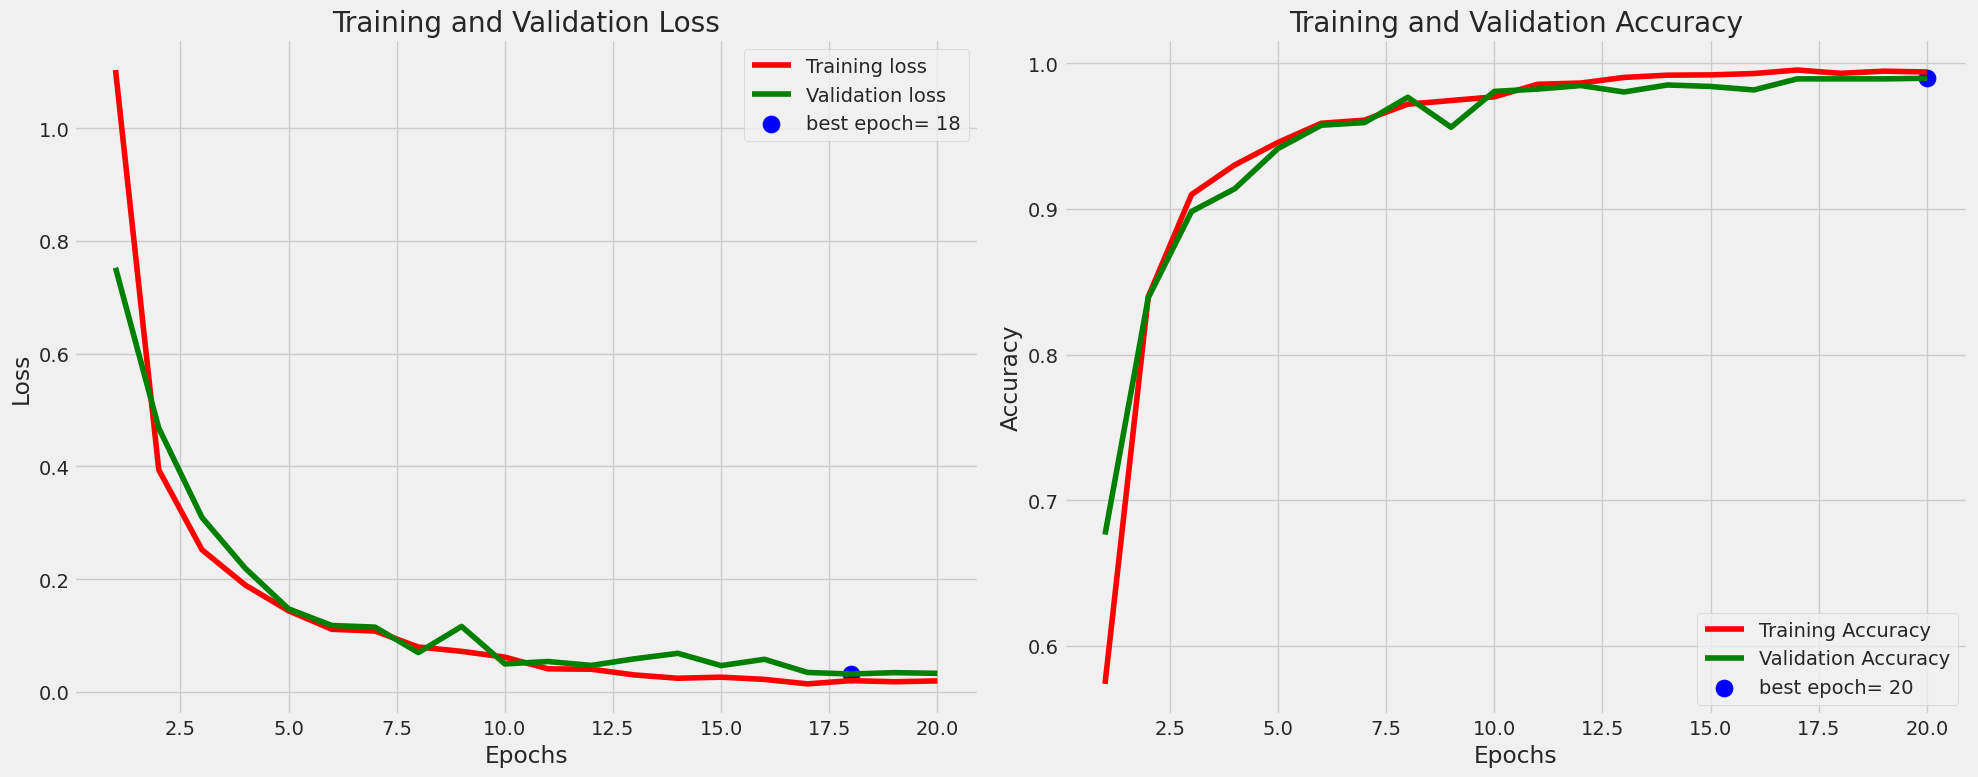

In [39]:
# Plot Loss-Acc Graphs:

plot_training_history(history)

157/157 [==============================] - 6s 37ms/step


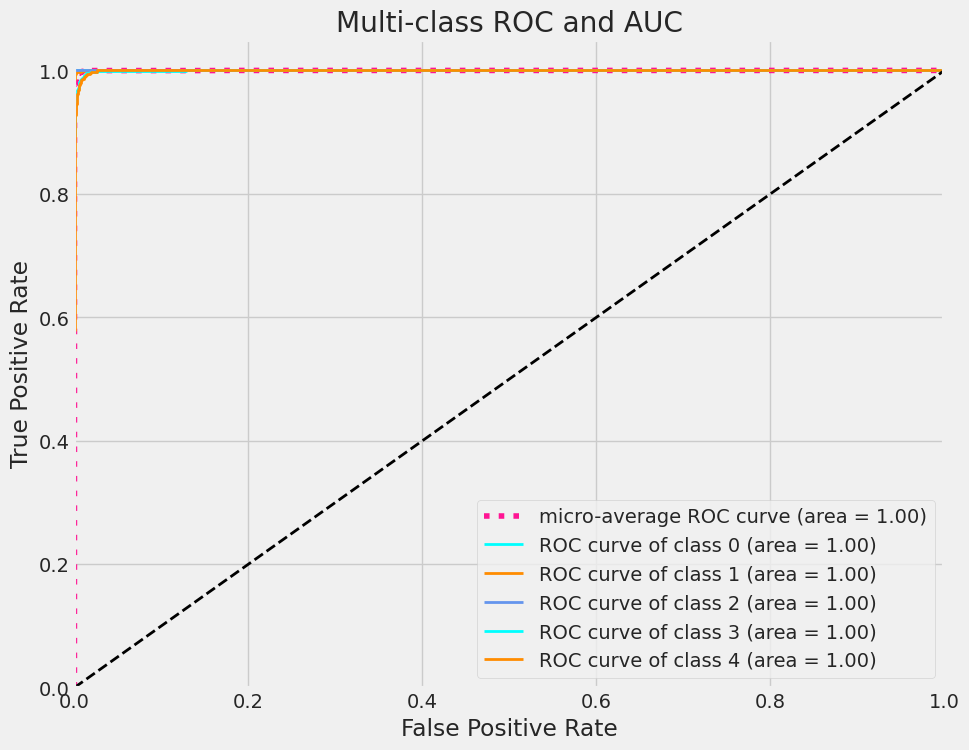

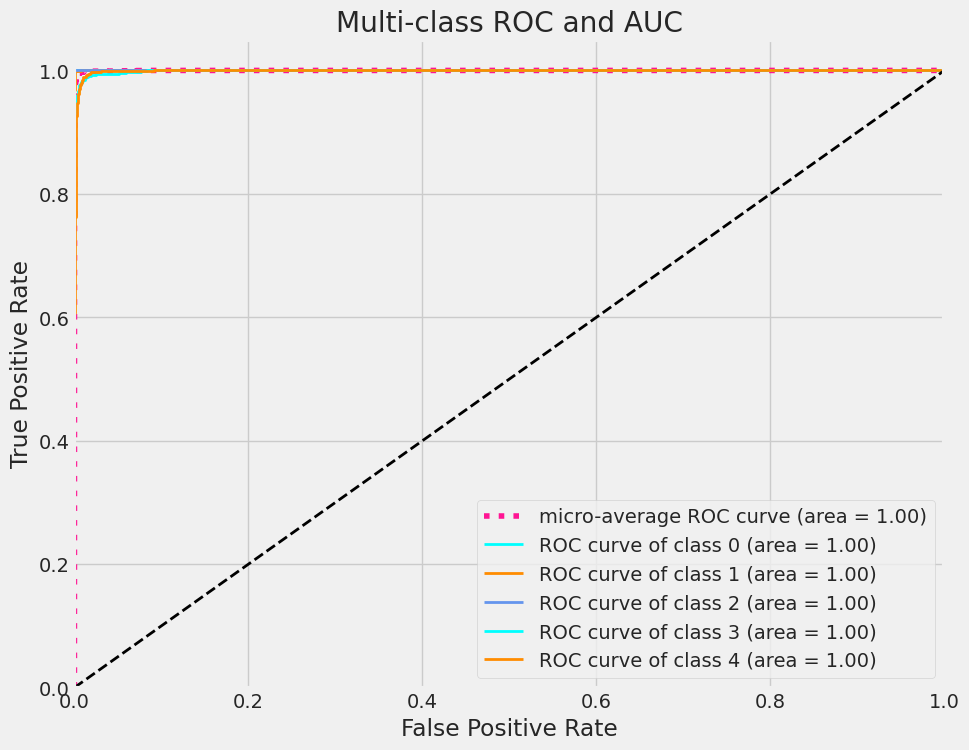

In [40]:
# Plotting ROC curvers :

## Get model predictions
y_val_pred_proba = model.predict(x_val)
y_test_pred_proba = model.predict(x_test)

## Convert predictions and true labels to class labels
y_val_pred = np.argmax(y_val_pred_proba, axis=1)
y_test_pred = np.argmax(y_test_pred_proba, axis=1)
y_val_true = np.argmax(y_val, axis=1)
y_test_true = np.argmax(y_test, axis=1)

## Plot ROC and calculate AUC for validation set
plot_multiclass_roc_auc(y_val_true, y_val_pred_proba, num_classes)

## Plot ROC and calculate AUC for test set
plot_multiclass_roc_auc(y_test_true, y_test_pred_proba, num_classes)


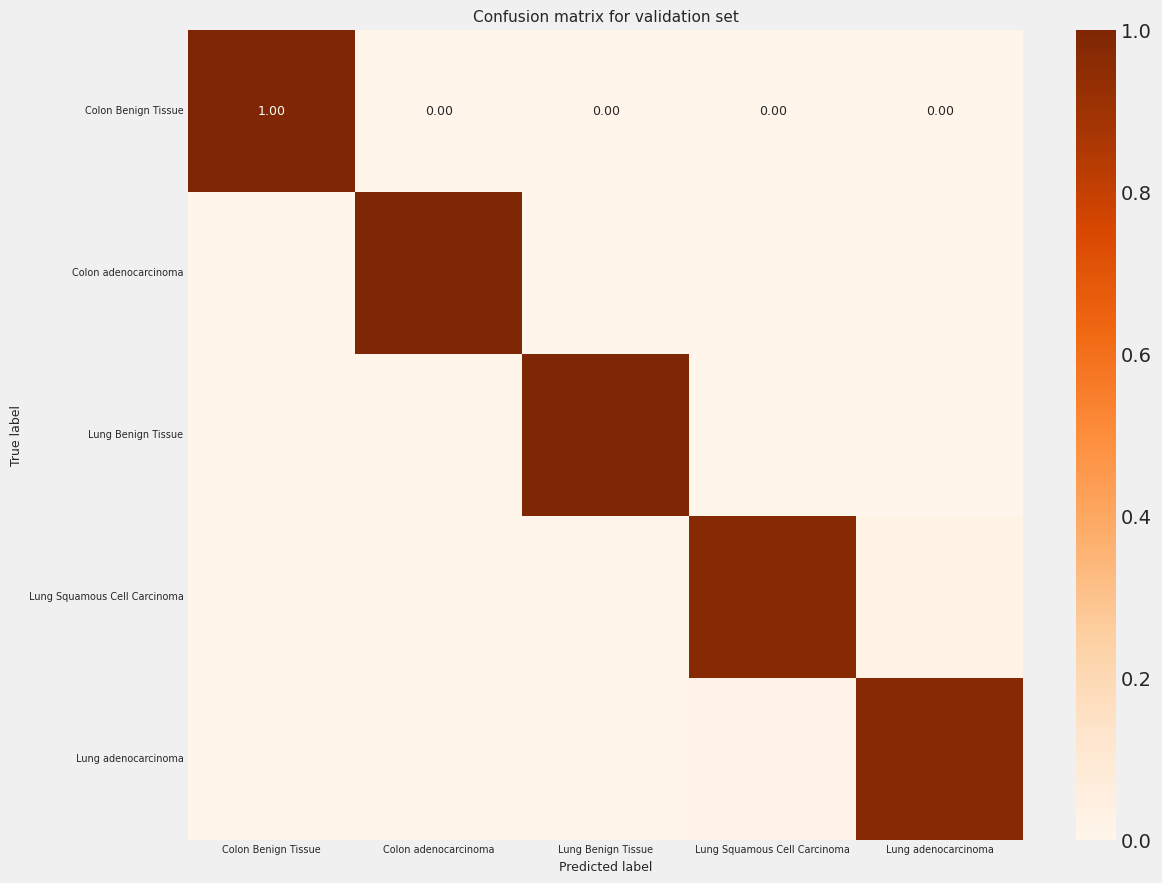

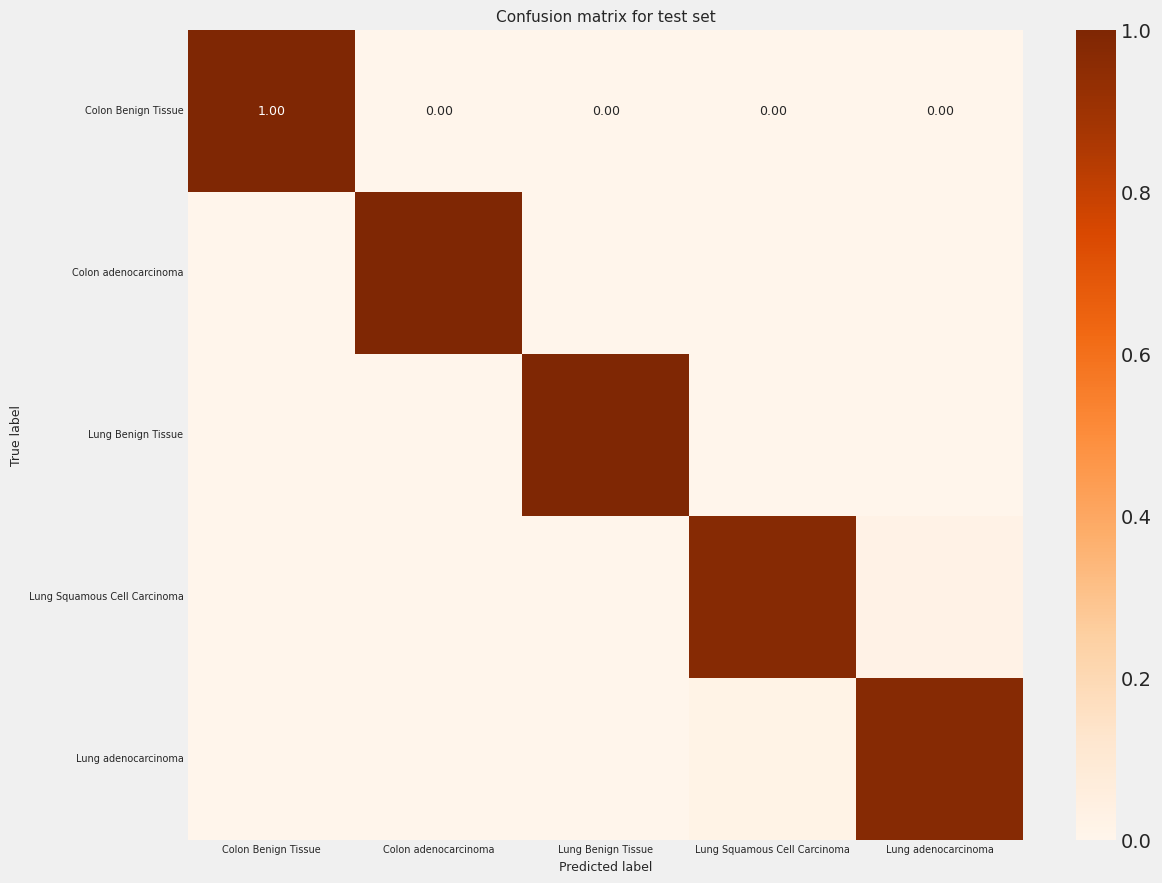

In [41]:


# Conf Matrix and classification Report:


## Extract unique class names from the `labels` array
unique_class_names = np.unique(labels)

## Map the class indices back to class names
y_val_true_names = indices_to_names(y_val_true, unique_class_names)
y_test_true_names = indices_to_names(y_test_true, unique_class_names)
y_val_pred_names = indices_to_names(y_val_pred, unique_class_names)
y_test_pred_names = indices_to_names(y_test_pred, unique_class_names)

## Plot confusion matrix for validation set with adjusted text size
plot_confusion_matrix(y_val_true_names, y_val_pred_names, classes=unique_class_names, title='Confusion matrix for validation set')

## Plot confusion matrix for test set with adjusted text size
plot_confusion_matrix(y_test_true_names, y_test_pred_names, classes=unique_class_names, title='Confusion matrix for test set')

In [42]:
## Calculate and print performance metrics for test set
print("\nTest Set Performance:")
print_performance_metrics(y_test_true, y_test_pred)

print(devider) 

## Calculate and print performance metrics for validation set
print("Validation Set Performance:")
print_performance_metrics(y_val_true, y_val_pred)


Test Set Performance:
Accuracy: 0.9900
Precision: 0.9900
Recall: 0.9900
F1-Score: 0.9900
-------------------------------------------------------------------------------------------------------------------------------------
Validation Set Performance:
Accuracy: 0.9896
Precision: 0.9896
Recall: 0.9896
F1-Score: 0.9896


NameError: name 'y_true' is not defined